In [1]:
#!pip install networkx --user
import numpy as np
import networkx as nx
print("Networkx version: {}".format(nx.__version__))
from time import time
import matplotlib.pyplot as plt
import random
import seaborn as sns
sns.set()

print("numpy version: {}".format(np.__version__))
print("Networkx version: {}".format(nx.__version__))

import ddot
from ddot import Ontology
from scipy.stats import norm
import numexpr
numexpr.print_versions()
%matplotlib inline

Networkx version: 1.11
numpy version: 1.19.2
Networkx version: 1.11
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Numexpr version:   2.7.3
NumPy version:     1.19.2
Python version:    3.7.10 (default, Feb 26 2021, 18:47:35) 
[GCC 7.3.0]
Platform:          linux-x86_64-#1 SMP Wed Oct 28 23:40:43 UTC 2020
CPU vendor:        
CPU model:         
CPU clock speed:    MHz
VML available?     True
VML/MKL version:   Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
Number of threads used by default: 8 (out of 16 detected cores)
Maximum number of threads: 64
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


In [2]:
import tensorflow as tf
print(tf.__version__)

import os
#print(os.environ['HOME'])
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

if tf.test.gpu_device_name() == '/device:GPU:0':
  print("Using a GPU")
else:
  print("Using a CPU")

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

from tensorflow_probability import edward2 as ed
tfd = tfp.distributions

#from numba import cuda 
#device = cuda.get_current_device()
#device.reset()

2.0.0
Using a CPU


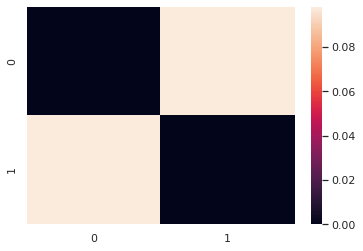

In [142]:
Gorig = nx.read_edgelist("data/matched/staging/rf_oob.avg.from_to.boost01Nov.tsv", delimiter='\t' , nodetype=str,  data=(('weight',float),))
for u,v,d in Gorig.edges(data=True):
    Gorig[u][v]['weight']= Gorig[u][v]['weight'] + np.random.normal(0,0.001)
#H = Gorig.subgraph(['ACD', 'ABL1', 'ACTL6A', 'ACTR5', 'ACTR8', 'ALKBH1', 'ALKBH2', 'ALKBH3'])
#mapping = {'ACD':6, 'ABL1':3, 'ACTL6A':7, 'ACTR5':5, 'ACTR8':0, 'ALKBH1':1, 'ALKBH2':2, 'ALKBH3':4}
H = Gorig.subgraph(['ACD', 'ABL1', 'ACTL6A', 'ACTR5', 'ACTR8', 'ALKBH3'])
mapping = {'ACD':6, 'ABL1':3, 'ACTL6A':7, 'ACTR5':5, 'ACTR8':0, 'ALKBH3':4}
G0 = nx.relabel_nodes(H, mapping)
A = nx.adjacency_matrix(G0).todense()
ax = sns.heatmap(A)

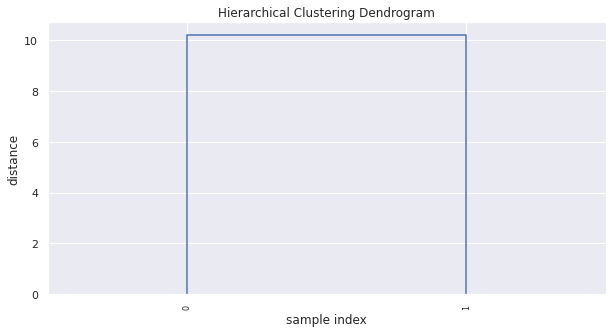

array([[ 0.        ,  1.        , 10.19480661,  2.        ]])

In [143]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

for u,v,d in G0.edges(data=True):
    G0[u][v]['weight']= 1.0/G0[u][v]['weight']

A = nx.adjacency_matrix(G0).todense()    
listA = squareform(A)
Z = linkage(listA, 'ward')

plt.figure(figsize=(10, 5))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()
Z

In [144]:
import networkx as nx
from networkx import relabel

Gnew = relabel.convert_node_labels_to_integers(Gorig, label_attribute = "term") #initilaization
terms = nx.get_node_attributes(Gnew, 'term')
len(terms)

336

In [145]:
import pandas as pd
print("pandas version: {}".format(pd.__version__))
#!!!! get a sub-branch of OG so that Gref becomes a subset of 306 genes
ont0 = pd.read_csv('data/pearl2015.txt', sep='\t', header=None)
ont = Ontology.from_table(ont0)
print(ont)
#df.to_csv('pdTest.csv')
Gref0 = ont.to_networkx()
genes = [u for u,v,e in Gref0.edges(data=True) if e[2] == 'Gene-Term']
genes = list(set(genes))
len(genes)

pandas version: 0.23.4
437 genes, 74 terms, 533 gene-term relations, 74 term-term relations
node_attributes: []
edge_attributes: [2]


437

In [146]:
match = []
for gene in genes:
    if gene in terms.values():
        match.append(gene)
len(match)

239

In [147]:
for node in Gref0.nodes():
    if len(Gref0.in_edges(node, data=True)) == 0: #terminal nodes
        Gref0.node[node]['level'] = 0
    else: Gref0.node[node]['level'] = -1
for parent in Gref0.successors('G2-M checkpoint'):
    print(parent)

Checkpoint factors


In [148]:
def get_level(level):
    for child in Gref0.nodes():
        if Gref0.node[child]['level'] == level: #get all nodes at level
            newLevel = level
            #print(child)
            for parent in Gref0.successors(child): #get parents one level above
                newLevel = level+1
                #print(parent)
                if newLevel > Gref0.node[parent]['level']: #check if the parent's level needs to be raised
                    Gref0.node[parent]['level'] = newLevel
                if child in match:
                    if parent not in match:
                        match.append(parent)
    return newLevel

for node in Gref0.nodes():
    if len(Gref0.in_edges(node, data=True)) == 0: #terminal nodes
        Gref0.node[node]['level'] = 0
    else: Gref0.node[node]['level'] = -1
level = 0
newLevel = 0
while  newLevel == level:
    newLevel = get_level(level)
    level += 1
    print(newLevel)
        
sorted(Gref0.nodes(data=True), key=lambda t: t[1].get('level', 1), reverse = True)

1
2
3
4
5
5


[('Repair pathway',
  {'NodeType': 'Term',
   'Size': 360,
   'isRoot': False,
   'Label': 'Repair pathway',
   'x_pos': 245.6241375729524,
   'y_pos': -123.4488005852734,
   'level': 5}),
 ('Associated process',
  {'NodeType': 'Term',
   'Size': 180,
   'isRoot': False,
   'Label': 'Associated process',
   'x_pos': 361.3382902011194,
   'y_pos': 384.6254287489511,
   'level': 4}),
 ('SSR',
  {'NodeType': 'Term',
   'Size': 114,
   'isRoot': False,
   'Label': 'SSR',
   'x_pos': 413.4151021365755,
   'y_pos': -491.5221691238521,
   'level': 3}),
 ('Telomere maintenance',
  {'NodeType': 'Term',
   'Size': 28,
   'isRoot': False,
   'Label': 'Telomere maintenance',
   'x_pos': 299.1150200444178,
   'y_pos': 654.2010548044404,
   'level': 3}),
 ('Ubiquitin response',
  {'NodeType': 'Term',
   'Size': 28,
   'isRoot': False,
   'Label': 'Ubiquitin response',
   'x_pos': 65.48671119842157,
   'y_pos': 293.88603403880245,
   'level': 3}),
 ('Alternative mechanism',
  {'NodeType': 'Term',
   

In [10]:
Gref = Gref0.subgraph(match)
genes = [u for u,v,e in Gref.edges(data=True) if e[2] == 'Gene-Term']
genes = list(set(genes))
len(genes)

239

In [11]:
#nx.write_graphml(Gref, "test.graphml")
G2 = nx.read_edgelist("data/resnik.txt", delimiter='\t' , nodetype=str,  data=(('weight',float),))
Gorig2 = G2.subgraph(match)
print(len(Gorig2))
ont2 = Ontology.from_networkx(Gref)
print(ont2)

239
239 genes, 62 terms, 324 gene-term relations, 62 term-term relations
node_attributes: ['level']
edge_attributes: [2]


In [12]:
#Define the joint_log_prob function, and our unnormalized posterior.
def SBM_log_prob(z, B, b0, directed=False, selfloops=False):
  # the SBM log-likelihood generative steps
    n = z.shape[0]
    #k = int(n/2)
    #pi = ed.Dirichlet(name='pi', concentration=np.ones(k), sample_shape=[n])
    #eta = tfd.Normal(loc=0, scale=0.01).sample([k,k]) #beta prior for simple edges
    #z = tf.reshape(tfd.Sample(tfd.Categorical(probs=pi),1).sample(), [n,])
    #z = tfd.Bernoulli(probs=pi).sample()
    #z0 = tf.cast(z, tf.float32)
    p = tf.matmul(tf.matmul(z,B),tf.transpose(z))
    A = tfd.Normal(loc=p+b0, scale=0.01)
    #    unsupervised tree/DAG shrinking by factors of 2, supervised grouping by suggesting mergers in a similar ratio 
    #    use tfd.MixtureSameFamily to automatically integrate out the z draws. Construct the mixture dist from pair-wise counting of z draws
    #    p = eta[(z.reshape((n, 1)), z.reshape((1, n)))][triu_indices] #replace with equation 5.5 for analytical posterior, including DC?
    #if weighted:
    #    A = ed.Poisson(name = 'A', mu=p, shape=A_obs[0].shape, observed=A_obs) #collect edge/non-edge statistics for the analytical posterior
    #else:
    return A

In [13]:
class VariationalEstep(tf.keras.Model):
#Optimizes pi and z with fixed phi, B, B0, (a, b are ommitted at the moment)

    def __init__(self, k, n, phi, name=None):
        super(VariationalEstep, self).__init__(name=name)
        self.pi = tf.Variable(tfd.Beta(concentration1=1, concentration0=1).sample([k]), name="pi",constraint=lambda x: tf.clip_by_value(x, 0, 1))
        self.phi = tf.Variable(phi, name="phi",constraint=lambda x: tf.clip_by_value(x, 0, 1))
        self.z = tf.Variable(tfd.RelaxedBernoulli(0.000001, probs=self.phi, validate_args=True, allow_nan_stats=False).sample(n), name="z",constraint=lambda x: tf.clip_by_value(x, 0, 1))
        #self.pi = tf.Variable(tfd.Beta(concentration1=1, concentration0=1).sample([k]), name="pi")
        #self.phi = tf.Variable(phi, name="phi")
        #self.z = tf.Variable(tfd.RelaxedBernoulli(0.000001, probs=self.phi, validate_args=True, allow_nan_stats=False).sample(n), name="z")
        #self.b0 = tf.Variable(tf.exp(tf.random.normal([1])), name='b0')
        #self.s_alpha = tf.Variable(tf.exp(tf.random.normal([1])), name='s_alpha')
        #self.s_beta = tf.Variable(tf.exp(tf.random.normal([1])), name='s_beta')
    
    #@property
    #def ppi(self):
    #    """Variational posterior for the Beta distribution"""
    #    return tfd.Beta(concentration1=self.s_alpha, concentration0=self.s_beta)
    
    @property
    def pz(self):
        """Variational posterior for the bias parameter"""
        #ppi2 = tfd.Beta(concentration1=self.s_a, concentration0=self.s_b)
        return tfd.Bernoulli(probs=self.pi)
    
    # for free z and pi learning    
    def call(self, GrefBlkVars, B0, k, n):
        """Predict p(y|x)"""
        #sample = lambda x: x.sample() if sampling else x.mean()
        return SBM_log_prob(self.z, GrefBlkVars, B0)
    
    def KLlosses(self,priorZ,power):
        """Sum of KL divergences between posteriors and priors"""
        prior = tfd.Bernoulli(probs=self.phi)
        # L-2 norm for sparsity + KL #consistency of the continous approximation
        return tf.reduce_sum(tf.pow(self.phi,-1))*10+tf.reduce_sum(tfd.kl_divergence(self.pz, prior))\
        +tf.reduce_sum(tf.abs(self.z-tf.cast(self.pz.sample(self.z.shape[0]), tf.float32)))*power\
        +tf.reduce_sum(tf.abs(self.z-priorZ))#incorporating prior for z
        
    def mUpdate(self, phiNew):
        """Sum of KL divergences between posteriors and priors"""
        self.phi = self.phi.assign(phiNew)

In [14]:
#import tensorflow.keras.backend as kerasB
Gnew = relabel.convert_node_labels_to_integers(H, label_attribute = "term") #initilaization
k = len(Gnew)
label = np.zeros(k)
label[1]=1
#label[2]=2
#label[3]=0
#label[4]=1
#label[5]=1
#label[k-1]=4
knew = int(max(label)+1)

# Prior design will be key here, needs external input
L_RATE = 0.005
batchSize = 20
n = len(Gnew)
optimizer = tf.keras.optimizers.Adam(lr=L_RATE)
Y = tf.cast(tf.stack([np.asarray(nx.to_numpy_matrix(Gnew))]*800), dtype=tf.float32)
data_train = tf.data.Dataset.from_tensor_slices(Y).batch(batchSize).shuffle(500)

#@tf.function
def E_step(y,GrefBlkVars,z):
    with tf.GradientTape() as tape:
        log_prob = tf.reduce_mean(model(GrefBlkVars,0.0,knew,n).log_prob(y))
        kl_loss = model.KLlosses(z,10)/n*100
        elbo_loss = kl_loss - log_prob
    gradients = tape.gradient(elbo_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return model

def M_step(z):
    with tf.GradientTape() as tape:
        #log_prob = tf.reduce_mean(model(GrefBlkVars,2.0,k2,n).log_prob(y))
        phi2 = tf.reduce_sum(z, 0)/n
        model.mUpdate(phi2)
    return GrefBlkVars

In [15]:
label

array([0., 1.])

In [16]:
# Function to compute the log posterior probability
import cProfile 
import itertools as it

phi = np.asarray([0.6,0.3]).astype("float32")
model = VariationalEstep(knew,len(Gnew),phi)
labelOneHot = tf.one_hot(label.astype(int), knew, dtype = "float32")
pz = tf.cast(ed.Bernoulli(probs=labelOneHot, name="z"), dtype=tf.float32)
labelnew = np.where(labelOneHot>0.5,1,0)

totalW = nx.to_numpy_matrix(Gnew).sum()
GrefBlkVars = np.random.normal(loc = totalW/len(Gnew)/(len(Gnew)-1)*2, scale = 1, size = (knew,knew))
for i in range(knew):
    for j in range(knew): 
        if (j==i): # only update diagonal entries for efficiency
            id1, id2 = zip(*it.product(np.where(labelnew[:,i]==1)[0],np.where(labelnew[:,j]==1)[0])) #cartesian product of the i j blocks
            totalW = sum(np.asarray(nx.to_numpy_matrix(Gnew))[id1, id2]) #total edge weights of the block pair
            GrefBlkVars[i,j] = totalW/len(id1) #averaged over possible edges of the block pair, needs upper-trianglize optimization
GrefBlkVars = tf.convert_to_tensor(np.maximum(GrefBlkVars, GrefBlkVars.T), dtype=tf.float32)

historyPi=[]
historyZ=[]
for (y_data) in data_train:
    posterior = E_step(y_data,GrefBlkVars,pz)
    #updates hyper parameters
    pi = posterior.pi.numpy()
    z = posterior.z.numpy()
    M_step(z)
    print(pi)
    historyPi.append(pi)
    historyZ.append(z)

/home/everyan/miniconda3/envs/tf-prob/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: tfp.edward2 module is deprecated and will be removed on 2019-12-01. Use https://github.com/google/edward2 library instead.
  


[0.06529686 0.12999798]
[0.07025722 0.13489555]
[0.07520063 0.1398488 ]
[0.08012851 0.14482918]
[0.08503987 0.14982021]
[0.08993277 0.15481147]
[0.09480492 0.15979557]
[0.09965402 0.16476676]
[0.10447785 0.16972025]
[0.10927403 0.1746523 ]
[0.11404035 0.17955942]
[0.11877508 0.18443838]
[0.12347613 0.18928668]
[0.12814125 0.19410127]
[0.13276865 0.19887972]
[0.13735673 0.2036191 ]
[0.14190423 0.20831615]
[0.14641005 0.21296789]
[0.15087274 0.21757221]
[0.15529133 0.22212704]
[0.15966515 0.22663078]
[0.16399318 0.23108228]
[0.16827415 0.23548023]
[0.1725069  0.23982377]
[0.17669035 0.2441118 ]
[0.18082356 0.24834315]
[0.18490566 0.25251645]
[0.18893622 0.25663024]
[0.19291471 0.2606831 ]
[0.19684054 0.26467344]
[0.20071343 0.26860037]
[0.20453273 0.27246282]
[0.2082975  0.27626026]
[0.21200694 0.2799914 ]
[0.21566036 0.28365436]
[0.21925719 0.28724784]
[0.22279666 0.29077053]
[0.22627814 0.29422116]
[0.22970133 0.29759842]
[0.23306602 0.3009011 ]


In [17]:
#import pandas as pd
#pd.DataFrame(ppi.numpy())
model.trainable_variables

[<tf.Variable 'pi:0' shape=(2,) dtype=float32, numpy=array([0.23306602, 0.3009011 ], dtype=float32)>,
 <tf.Variable 'z:0' shape=(2, 2) dtype=float32, numpy=
 array([[1.5278296e-03, 2.6442172e-04],
        [8.3149600e-01, 8.4599191e-01]], dtype=float32)>]

In [18]:
# Merge quasi-cliques with more than 3 overlapping nodes
def merge_cliques(Clist):
    for i in range(0, len(Clist)):
        c1 = Clist[i]
        for j in range(i+1, len(Clist)):
            c2 = Clist[j]
            if (len(c1.intersection(c2))>1): # define quasi-cliques with number of overlapping nodes
                c3 = c1.union(c2)
                Clist.insert(0,c3)
                Clist.remove(c1)
                Clist.remove(c2)
                return merge_cliques(Clist)
    return Clist

In [19]:
import networkx.algorithms.clique as clique
import itertools as it
import random 

def getCandidatesB(G, Gref, terms, topE, maxC, maxP):
    parentList = []
    childList= []
    nodeIndex = 0
    for source in terms.values():
        if source in Gref.nodes(): #matched leaf nodes (genes for first layer)
            for target in Gref.successors(source):
                tup = (target,Gref.node[target]['level'])
            tup2 = (source,nodeIndex)
            parentList.append(tup)
            childList.append(tup2)
            nodeIndex = nodeIndex + 1
    parentSet = list(set(parentList))
    childSet = list(set(childList))

    merges = []
    for parent in parentSet:
        c = []
        for predecessor in Gref.predecessors(parent[0]): 
            if len(Gref.in_edges(predecessor, data=True)) == 0: #only include leaves
                if predecessor in terms.values():
                    c.append(predecessor)
        merges.append(set(c))
    CliXO = {}    
    nodeSet = sorted(set().union(*merges))
    for x in nodeSet:
        CliXO[x] = []
        for idx, y in enumerate(merges): 
            if (x in y): #only top 2 appearance are considered in Bayesian assignments
                CliXO[x].append(idx)
    k = len(G) #original block number = graph size
    labels = np.arange(k)
    maxLabel = len(merges)
    #print(maxLabel)
    #print(len(nodeSet))
    knew = k+maxLabel-len(nodeSet) #new block number after mergers
    label1hot = np.zeros([k,knew])
    #print(label1hot.shape)
    labelCount = 0
    for idx, row in enumerate(label1hot):
        if idx<len(nodeSet):
            if (childSet[idx][0] in CliXO): #node to be merged according to CliXO
                #print(childSet[idx][0])
                label1hot[childSet[idx][1],CliXO[childSet[idx][0]]] = 1.0
        else:
            label1hot[idx,maxLabel+labelCount] = 1.0
            labelCount = labelCount+1
    if (maxLabel<=5):
        #print("Adding CliXO candidates")
        label1hot = getCandidates(G, topE, maxC, maxP)
    return label1hot

In [20]:
import networkx.algorithms.clique as clique
import itertools as it

def getCandidates(G, top, maxC, maxP):
    edgesTop=sorted(G.edges(data=True), key=lambda t: t[2].get('weight', 1), reverse=True)
    #percent = int(len(edgesTop)/5000) # adjust for layer size
    eList = [(x[0],x[1]) for x in edgesTop[:top]]
    nodeSet = set().union(*eList)
    sub = G.subgraph(nodeSet)
    graphs = [sub.subgraph(c) for c in nx.connected_components(sub)]
    #print(len(graphs))
    max_clique_sets = [clique.find_cliques(s) for s in graphs]
    cliques = []
    for clist in max_clique_sets:
        tmp = []
        for c in clist:
            if ((len(c)>=2) & (len(c)<=maxC)): #control size of cliques
                cohesion = 0
                for idx, x in enumerate(c):
                    for idy, y in enumerate(c):
                        if (idy>idx):
                            cohesion = cohesion + G[x][y]['weight']
                tup = (set(c),cohesion/(len(c)-1)) #higher order cliques prioritized
                tmp.append(tup)
        tmp = sorted(tmp, key=lambda t: t[1], reverse=True) #sort cliques
        cliques += tmp[:5] #keep only top 3 cliques for each component
    
    CliList = sorted(cliques, key=lambda t: t[1], reverse=True)
    #print(CliList)
    cliquesFiltered0 = [x[0] for x in CliList]
    cliquesFiltered = merge_cliques(cliquesFiltered0)

    CliXO = {}    
    nodeSet = sorted(set().union(*cliquesFiltered))
    for x in nodeSet:
        CliXO[x] = []
        for idx, y in enumerate(cliquesFiltered): 
            if (x in y) and len(CliXO[x])<maxP: #only top 2 appearance are considered in Bayesian assignments
                CliXO[x].append(idx)
    k = len(G) #original block number = graph size
    labels = np.arange(k)
    maxLabel = len(cliquesFiltered)
    knew = k+maxLabel-len(nodeSet) #new block number after mergers
    label1hot = np.zeros([k,knew])
    #print(label1hot.shape)
    labelCount = 0
    for idx, row in enumerate(label1hot):
        if (idx in CliXO): #node to be merged according to CliXO
            label1hot[idx,CliXO[idx]] = 1.0
        else:
            label1hot[idx,maxLabel+labelCount] = 1.0
            labelCount = labelCount+1
    return label1hot

In [21]:
def buildLayer(GnewL, Gref, labelOneHot):
    batchSize = 20
    Y = tf.cast(tf.stack([nx.to_numpy_matrix(GnewL)]*100), dtype=tf.float32)
    data_train = tf.data.Dataset.from_tensor_slices(Y).batch(batchSize).shuffle(1000)
    n = len(GnewL)
    
    Mlist = []
    knew = labelOneHot.shape[1]
    ppz = ed.Bernoulli(probs=labelOneHot, name="z").numpy().astype("float32")
    phi = tf.reduce_sum(ppz, 0)/n
    # set initial state (drawn from prior built from OG subgraphs)
    # Prior strength tuning parameter
    # Prior design will be key here, needs external input from corresponding OG layer
    modelInner = VariationalEstep(knew,n,phi)
    totalW = sum(sum(nx.to_numpy_matrix(Gref)))
    GrefBlkVars = np.random.normal(loc = totalW/len(Gref)/(len(Gref)-1)*2, scale = 1, size = (knew,knew))
    labelnew = np.where(labelOneHot>0.5,1,0)
    for i in range(knew):
        if len(np.where(labelnew[:,i]==1)[0])>0:
            for j in range(knew): 
                if (j==i) & len(np.where(labelnew[:,j]==1)[0])>0 : # only update diagonal entries for efficiency
                    id1, id2 = zip(*it.product(np.where(labelnew[:,i]==1)[0],np.where(labelnew[:,j]==1)[0])) #cartesian product of the i j blocks
                    totalW = sum(nx.to_numpy_matrix(Gref)[id1, id2]) #total edge weights of the block pair
                    GrefBlkVars[i,j] = totalW/len(id1) #averaged over possible edges of the block pair, needs upper-trianglize optimization
    GrefBlkVars = tf.convert_to_tensor(np.maximum(GrefBlkVars, GrefBlkVars.T), dtype=tf.float32)

    for (y_data) in data_train:
        with tf.GradientTape() as tape:
            log_prob = tf.reduce_mean(modelInner(GrefBlkVars,0.0,knew,n).log_prob(y_data))
            kl_loss = modelInner.KLlosses(ppz)/n*100
            elbo_loss = kl_loss - log_prob
        gradients = tape.gradient(elbo_loss, modelInner.trainable_variables)
        optimizer.apply_gradients(zip(gradients, modelInner.trainable_variables))
        phi2 = tf.reduce_sum(modelInner.z, 0)/n
        phi2 = np.where(phi2<0.2,0,phi2) #Adjust for different thresholds
        modelInner.mUpdate(phi2)
    return (log_prob,modelInner) #higher order cliques prioritized

In [22]:
def buildLayerB(GnewL, Gref, labelOneHot, power):
    batchSize = 20
    Y = tf.cast(tf.stack([np.asarray(nx.to_numpy_matrix(GnewL))]*100), dtype=tf.float32)
    data_train = tf.data.Dataset.from_tensor_slices(Y).batch(batchSize).shuffle(1000)
    n = len(GnewL)
    
    Mlist = []
    knew = labelOneHot.shape[1]
    ppz = ed.Bernoulli(probs=labelOneHot, name="z").numpy().astype("float32")
    phi = tf.reduce_sum(ppz, 0)/n
    # set initial state (drawn from prior built from OG subgraphs)
    # Prior strength tuning parameter
    # Prior design will be key here, needs external input from corresponding OG layer
    modelInner = VariationalEstep(knew,n,phi)
    totalW = nx.to_numpy_matrix(GnewL).sum()
    GrefBlkVars = np.random.normal(loc = totalW/len(GnewL)/(len(GnewL)-1)*2, scale = 1, size = (knew,knew))
    labelnew = np.where(labelOneHot>0.5,1,0)
    for i in range(knew):
        if len(np.where(labelnew[:,i]==1)[0])>0:
            for j in range(knew): 
                if (j==i) & len(np.where(labelnew[:,j]==1)[0])>0 : # only update diagonal entries for efficiency
                    id1, id2 = zip(*it.product(np.where(labelnew[:,i]==1)[0],np.where(labelnew[:,j]==1)[0])) #cartesian product of the i j blocks
                    totalW = sum(np.asarray(nx.to_numpy_matrix(GnewL))[id1, id2]) #total edge weights of the block pair
                    GrefBlkVars[i,j] = totalW/len(id1) #averaged over possible edges of the block pair, needs upper-trianglize optimization
    GrefBlkVars = tf.convert_to_tensor(np.maximum(GrefBlkVars, GrefBlkVars.T), dtype=tf.float32)
    
    for (y_data) in data_train:
        with tf.GradientTape() as tape:
            log_prob = tf.reduce_mean(modelInner(GrefBlkVars,0.0,knew,n).log_prob(y_data))
            kl_loss = modelInner.KLlosses(ppz,10)/n*100 #update ppz for Bayesian power
            elbo_loss = kl_loss - log_prob
        gradients = tape.gradient(elbo_loss, modelInner.trainable_variables)
        optimizer.apply_gradients(zip(gradients, modelInner.trainable_variables))
        phi2 = tf.reduce_sum(modelInner.z, 0)/n
        phi2 = np.where(phi2<0.2,0,phi2) #Adjust for different thresholds
        modelInner.mUpdate(phi2) #update phi2 for Bayesian power
    modelInner.z = modelInner.z*(1-power)+ppz*power
    return (log_prob,modelInner)

In [23]:
def updateDAG(G, NodeMerge, terms):
    size = len(NodeMerge);
    nodeSet = sorted(set().union(*NodeMerge))
    A = nx.adjacency_matrix(G).todense()
    while len(NodeMerge)>0:
        nodes = NodeMerge.pop()
        newNodeV = np.sum(A[nodes,:],axis=0)/len(nodes)
        B = np.vstack([A, newNodeV])
        newNodeC = np.sum(B[:,nodes],axis=1)/len(nodes)
        A = np.column_stack([B, newNodeC])
        
    #print(nodeSet)
    A = np.delete(A, nodeSet, axis = 0)
    #print(A.shape)
    A = np.delete(A, nodeSet, axis = 1)
    dt=[('weight',float)]
    A = np.matrix(A,dtype=dt)
    np.fill_diagonal(A, 0)
    Gnew = nx.from_numpy_matrix(A)
    Gnew = relabel.convert_node_labels_to_integers(Gnew,label_attribute = "term") 
    
    for node in nodeSet:
        if node in terms:
            del terms[node]
    return Gnew, {i:v for i,(k,v) in enumerate(terms.items(),0)}

In [24]:
def updateDAGB(G, Gref, NodeMerge, internals, terms):    
    size = len(NodeMerge);
    nodeSet = sorted(set().union(*NodeMerge))
    A = nx.adjacency_matrix(G).todense()
    mapping = []

    while len(NodeMerge)>0:
        nodes = NodeMerge.pop()
        internal = internals.pop()
        newNodeV = np.sum(A[nodes,:],axis=0)/len(nodes)
        B = np.vstack([A, newNodeV])
        newNodeC = np.sum(B[:,nodes],axis=1)/len(nodes)
        A = np.column_stack([B, newNodeC])
        #updating the ref graph if merger is matched perfectly
        parentRefs = []
        #print("mergers: ") 
        for kid in nodes:
            #print(terms[kid])
            if (terms[kid] in Gref):
                parentRefs.append(set([n for n in Gref.successors(terms[kid])]))
        #print("internals: ")
        #print(internal)
        if len(parentRefs)>0:
            parentRefs0 = set(parentRefs[0]).intersection(*parentRefs)
            if len(parentRefs0)>0:
                theParent = parentRefs0.pop()
                kidsTerms = [terms[node] for node in nodes]
                if kidsTerms == [n for n in Gref.predecessors(theParent)]:
                    mapping.append({internal:theParent})
                    Gref = nx.relabel_nodes(Gref, {theParent:internal})
                    for kid in nodes:
                        if (terms[kid] in Gref):
                            Gref.remove_node(terms[kid])

    #print(nodeSet)
    A = np.delete(A, nodeSet, axis = 0)
    #print(A.shape)
    A = np.delete(A, nodeSet, axis = 1)
    dt=[('weight',float)]
    A = np.matrix(A,dtype=dt)
    np.fill_diagonal(A, 0)
    Gnew = nx.from_numpy_matrix(A)
    Gnew = relabel.convert_node_labels_to_integers(Gnew,label_attribute = "term") 

    for node in nodeSet:
        if node in terms:
            del terms[node]
    return Gnew, Gref, mapping, {i:v for i,(k,v) in enumerate(terms.items(),0)}

In [25]:
Gorig2

In [111]:
from collections import Counter
from networkx import relabel
import cProfile 
import itertools as it
import ddot
from ddot import Ontology

Gorig0 = nx.read_edgelist("data/new/co-expression.tsv", delimiter='\t' , nodetype=str,  data=(('weight',float),))
Gorig2 = Gorig0.subgraph(match)

def f(thresh,power,batch,maxC,maxP,Gorig2):
    Gnew = relabel.convert_node_labels_to_integers(Gorig2, label_attribute = "term") #initilaization
    terms = nx.get_node_attributes(Gnew, 'term') # initilaizatial dictionary for ddot ontology output
    maps = [] # for ddot ontology output
    gModel = [] # for generative modeling
    subsystem = 0 # for ddot ontology output
    loop=0
    L_RATE = 0.005
    optimizer = tf.keras.optimizers.Adam(lr=L_RATE)
    #
    Gref = ont.to_networkx()
    #Gref = nx.from_pandas_edgelist(df,1,0,[2],nx.DiGraph)
    for node in Gref.nodes():
        if len(Gref.in_edges(node, data=True)) == 0: #terminal nodes
            Gref.node[node]['level'] = 0
        else: Gref.node[node]['level'] = -1
    level = 0
    newLevel = 0
    while  newLevel == level:
        newLevel = get_level(level)
        level += 1

    print("entering supervised stage")        
    #consistency between ref and bayesian posterior required after Supervised levels    
    while True:
        k = len(Gnew)
        #print(k)
        label1hot = getCandidatesB(Gnew, Gref, terms, batch, maxC, maxP) #G, top, maxC, maxP
        #label1hot = getCandidates(Gnew, 500, 50, 5) #G, top, maxC, maxP
        #combine label1hot with label1hot0's additional columns via a Bayesian parameter
        if label1hot.shape[1]<= 1: #catch final top block before merging
            print("root block")
            break 
        ModelPosterior = buildLayerB(Gnew, Gref, label1hot, power)
        #print(np.max(ModelPosterior[1].z.numpy())) 
        #newInternal = np.where(np.asarray(ModelPosterior) > thresh)[0] #keep Bayesian candidates above threshold

        NodeMerge = [] #nodes to be merged, nested lists of motifs
        newNode = []
        #for node in Gnew.nodes():
            #gModel.append(str(loop)+"th loop:"+terms[node])

        newLabel = ModelPosterior[1].z.numpy()
        threshold = max(thresh,np.percentile(newLabel, 50))#-0.05*(loop))
        newLabelC = np.where(newLabel>=threshold,1,0) #Adjust for different thresholds
        dup = np.where(np.sum(newLabelC,axis=0)>0)[0] #list only duplicate labels where merges could happen
        #newCount = label1hot.shape[0] + len(dup)
        #print(threshold)
        #print(power)
        #print(batch)
        for dupL in dup: 
            nodes = np.where(newLabelC[:,dupL]>0)[0] #[0] to strip np.where outer brackets
            #print(nodes)
            #if(all(not set(nodes).issubset(set(x)) for x in NodeMerge)):
            NodeMerge.append(nodes)
            for node in nodes: #update ddot ontology with new merges
                gModel.append((terms[node],"subsystem"+str(subsystem),"zPosterior:", newLabel[node,dupL])) #update ddot ontology
            terms[len(terms)] = "subsystem"+str(subsystem)
            newNode.append(terms[len(terms)-1])
            subsystem += 1
        #gModel.append((str(loop)+"th posterior",newLabel))
        nodeSet = sorted(set().union(*NodeMerge))
        #print(len(nodeSet))
        #newCount = newCount - len(nodeSet)
        Gnew, Gref, mapping, terms = updateDAGB(Gnew, Gref, NodeMerge, newNode, terms) #update the graph with node mergers/splits  
        maps.append(mapping)
        #print("looping")
        loop += 1
        if loop>30:
            print("breaking")
            break
    
    if (loop <=30 ):
        hierarchy  = [x for x in gModel if "subsystem" in str(x[0])]
        mapping = [x for x in gModel if "subsystem" not in str(x[0])]
        ontOut = Ontology(hierarchy, mapping)
    else: #forced empty ont for breaking DAGs
        hierarchy  = [x for x in gModel if "subsystemOMG" in str(x[0])]
        mapping = [x for x in gModel if "subsystemOMG" in str(x[0])]
        ontOut = Ontology(hierarchy, mapping)
    print(ontOut)
    return maps, ontOut

#cProfile.run('f(0.2,0.9,20)')
maps, ontOut = f(0.1,0.2,5,50,5,Gorig0)

entering supervised stage
root block
306 genes, 1342 terms, 723 gene-term relations, 2590 term-term relations
node_attributes: []
edge_attributes: []


In [112]:
# Include all transitive connections between genes and terms
ont2 = ontOut.propagate(direction='forward', gene_term=True, term_term=False)
len(ont2.genes)

306

In [113]:
Gorth = nx.read_edgelist("data/matched/reactome", delimiter='\t' , nodetype=str)
len(Gorth)

292

In [114]:
match = []
for gene in ont2.genes:
    if gene in Gorth:
        match.append(gene)
len(match)

275

In [119]:
Gorth.nodes()

['ATRX',
 'NBN',
 'TOP2B',
 'SMC1A',
 'MBD4',
 'RAD50',
 'ATRIP',
 'RAD17',
 'RAD1',
 'FAAP100',
 'CLSPN',
 'RFC5',
 'ERCC1',
 'RAD9A',
 'ATM',
 'ERCC4',
 'RFC3',
 'RFC2',
 'MCM10',
 'ATR',
 'FANCD2',
 'RAD52',
 'BRIP1',
 'RPA2',
 'WRN',
 'RMI1',
 'CDC7',
 'RBBP8',
 'CCNA2',
 'TIPIN',
 'HUS1',
 'EXO1',
 'TIMELESS',
 'FANCG',
 'FANCF',
 'FANCE',
 'FANCC',
 'FANCB',
 'FANCA',
 'RFC4',
 'FAAP20',
 'FANCM',
 'FANCL',
 'FAAP24',
 'FANCI',
 'CHEK1',
 'BRCA1',
 'BRCA2',
 'RMI2',
 'BARD1',
 'ORC6',
 'ORC5',
 'ORC2',
 'ORC1',
 'BLM',
 'MCM6',
 'MCM5',
 'DNA2',
 'MCM7',
 'MCM2',
 'MCM8',
 'MCM3',
 'TP53',
 'TOPBP1',
 'RPA1',
 'RPA3',
 'CDK2',
 'MCM4',
 'RAD51',
 'CDC45',
 'TOP3A',
 'UBE2T',
 'DHX9',
 'XRCC5',
 'TOP2A',
 'POLR2D',
 'POLR2G',
 'HNRNPR',
 'HNRNPUL1',
 'XAB2',
 'HMGB1',
 'PRPF19',
 'TRA2B',
 'XPC',
 'RAD23A',
 'SUMO2',
 'CHAF1A',
 'RAD23B',
 'RAD51D',
 'CETN2',
 'DDB2',
 'GTF2H1',
 'DDB1',
 'ERCC2',
 'PCNA',
 'ERCC3',
 'SMARCB1',
 'GTF2H3',
 'XPA',
 'MNAT1',
 'PARP1',
 'GTF2H5',
 'G

In [115]:
pool = ont2.term_2_gene['subsystem27'] #all genes connected with the term
total2 = len(pool)*(len(pool)-1)/2
geneSet = [] #for collecting gene pairs
if len(pool)>1: #make sure the system has more than 1 gene 
    for idx in pool: #grabbing genes
        geneSet.append(ont2.genes[idx])
    subG = sim.subgraph(geneSet) #get the subgraph corresponding to the system

'ADNP'

In [125]:
import scipy.stats as stats
#inputs: sim, similarity network between genes;
#        ont, ontology DAG of with genes at the leaves
#output: number of edges in sim that is significantly enriched in ont
def hypergeometricTestPairCount(sim, ont):
    total = len(sim)*(len(sim)-1)/2
    eCount = len(sim.edges())
    pairCollect = set() #for collecting significant edges
    #propagate genes to full pathways
    ont2 = ont.propagate(direction='forward', gene_term=True, term_term=False)
    for system in ont2.term_2_gene: #per internal terms
        pool = ont2.term_2_gene[system] #all genes connected with the term
        geneSet = [] #for collecting gene pairs
        if len(pool)>1: #make sure the system has more than 1 gene 
            for idx in pool: #grabbing gene ids
                if ont2.genes[idx] in sim.nodes(): #filter for genes in the network
                    geneSet.append(ont2.genes[idx]) #add gene name
            total2 = len(geneSet)*(len(geneSet)-1)/2
            subG = sim.subgraph(geneSet) #get the subgraph corresponding to the system
            eCount2 = len(subG.edges())
            #print(total-total2-eCount)
            #print(total2-eCount2)
            oddsratio, pvalue = stats.fisher_exact([[eCount, total-total2-eCount], [eCount2, total2-eCount2]])
            eList = set([frozenset(pair) for pair in subG.edges()])
            #print("pvalue is ")
            #print(pvalue)
            if pvalue<0.01:
                pairCollect.update(eList)
        #Need to handle case for 1 gene system 
        #Need to handle len(pool)=len(sim) 
    if len(pairCollect)>len(sim.edges()):
        print("overcounted")
    return(len(pairCollect))

In [34]:
table = ontOut.align(ont2,calculateFDRs="../../alignOntology/calculateFDRs")
count = len(table[table['FDR']<=0.2])
print(count)
table

collapse command: /home/everyan/miniconda3/envs/tf-prob/lib/python3.7/site-packages/ddot/alignOntology/collapseRedundantNodes /tmp/tmp7otbye5_
collapse command: /home/everyan/miniconda3/envs/tf-prob/lib/python3.7/site-packages/ddot/alignOntology/collapseRedundantNodes /tmp/tmpvdfhaj_r
Alignment command: ../../alignOntology/calculateFDRs /tmp/tmpq6gnn17w /tmp/tmpcelo4pqu 0.05 criss_cross /tmp/tmp7f41a37q 100 16 gene
3


,Term,Similarity,FDR
Term,,,
subsystem6,G1-CC phase,0.208229,0.030
subsystem180,Chromosome segregation,0.273037,0.080
subsystem15,LONG PATCH-BER factors,0.159111,0.075


In [71]:
ndex_server = 'http://test.ndexbio.org' 

# Set the NDEx server and the user account (replace with your own account)
ndex_user, ndex_pass = 'xiaoran.a.yan', 'a1l9i8f4e3'
url, _ = ontOut.to_ndex(ndex_server=ndex_server, ndex_user=ndex_user, ndex_pass=ndex_pass)
print(url)

https://test.ndexbio.org/v2/network/37984c91-8c12-11eb-a047-0660b7976219


In [152]:
Gorig0 = nx.read_edgelist("data/new/co-expression.tsv", delimiter='\t' , nodetype=str,  data=(('weight',float),))
Gorth = nx.read_edgelist("data/matched/reactome", delimiter='\t' , nodetype=str)
maps, ont0 = f(0.1,0.2,5,50,5,Gorig0)
match = []
for gene in ont0.genes:
    if gene in Gorth:
        match.append(gene)
Gorig2 = Gorig0.subgraph(match)
threshList =  [0.1,0.3,0.5,0.7,0.9]# [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
powerList = [0.0,0.3]
batchList = [150,50,15,5]
topCount = 0
butPower = 1
topOnt = []
topHyper = []
for thresh in threshList: 
    for power in powerList:
        for batch in batchList:
            maps, ontOut = f(thresh, power, batch,50,5,Gorig2)
            count = hypergeometricTestPairCount(Gorth,ontOut)
            topOnt.append(ontOut)
            topHyper.append({"thresh":thresh, "power":power, "batch":batch, "systemCount":len(ontOut.terms),"matchCount":count})
            print(thresh,power,count)
            if (count > topCount) | ((count == topCount) & (power < butPower)):
                topCount = count
                butPower = power
                topMap = maps

entering supervised stage
root block
306 genes, 1382 terms, 725 gene-term relations, 2734 term-term relations
node_attributes: []
edge_attributes: []
entering supervised stage
root block
275 genes, 408 terms, 478 gene-term relations, 582 term-term relations
node_attributes: []
edge_attributes: []
0.1 0.0 3937
entering supervised stage
root block
275 genes, 420 terms, 461 gene-term relations, 604 term-term relations
node_attributes: []
edge_attributes: []
0.1 0.0 3937
entering supervised stage
root block
275 genes, 931 terms, 432 gene-term relations, 1435 term-term relations
node_attributes: []
edge_attributes: []
0.1 0.0 3937
entering supervised stage
breaking
0 genes, 0 terms, 0 gene-term relations, 0 term-term relations
node_attributes: []
edge_attributes: []
0.1 0.0 0
entering supervised stage
breaking
0 genes, 0 terms, 0 gene-term relations, 0 term-term relations
node_attributes: []
edge_attributes: []
0.1 0.3 0
entering supervised stage
root block
275 genes, 255 terms, 668 gene-te

In [151]:
topHyper

[{'thresh': 0.1,
  'power': 0.0,
  'batch': 150,
  'systemCount': 757,
  'matchCount': 3043},
 {'thresh': 0.1,
  'power': 0.0,
  'batch': 50,
  'systemCount': 757,
  'matchCount': 3043},
 {'thresh': 0.1,
  'power': 0.0,
  'batch': 15,
  'systemCount': 757,
  'matchCount': 3043},
 {'thresh': 0.1,
  'power': 0.0,
  'batch': 5,
  'systemCount': 757,
  'matchCount': 3043},
 {'thresh': 0.1,
  'power': 0.3,
  'batch': 150,
  'systemCount': 757,
  'matchCount': 3043},
 {'thresh': 0.1,
  'power': 0.3,
  'batch': 50,
  'systemCount': 757,
  'matchCount': 3043},
 {'thresh': 0.1,
  'power': 0.3,
  'batch': 15,
  'systemCount': 757,
  'matchCount': 3043},
 {'thresh': 0.1,
  'power': 0.3,
  'batch': 5,
  'systemCount': 757,
  'matchCount': 3043},
 {'thresh': 0.3,
  'power': 0.0,
  'batch': 150,
  'systemCount': 757,
  'matchCount': 3043},
 {'thresh': 0.3,
  'power': 0.0,
  'batch': 50,
  'systemCount': 757,
  'matchCount': 3043},
 {'thresh': 0.3,
  'power': 0.0,
  'batch': 15,
  'systemCount': 757,

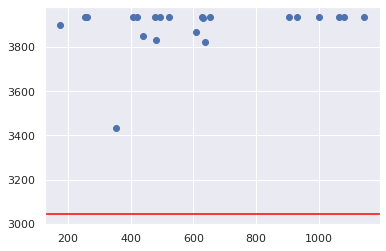

In [153]:
x_val = []
y_val = []
for point in topHyper:
    if (point['systemCount']>0):
        x_val.append(point['systemCount'])
        y_val.append(point['matchCount'])
plt.scatter(x_val,y_val)
plt.axhline(3043,color="red")

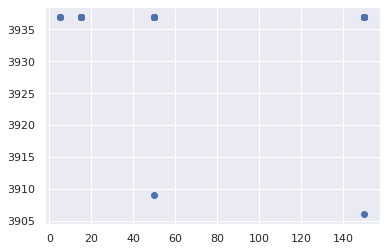

In [64]:
x_val = []
y_val = []
for point in topHyper:
    if (point['systemCount']>0):
        x_val.append(point['batch'])
        y_val.append(point['matchCount'])
plt.scatter(x_val,y_val)

In [129]:
ont2 = topOnt[0].propagate(direction='forward', gene_term=True, term_term=False)
hypergeometricTestPairCount(Gorth,ont2)

3937

In [130]:
ont2 = topOnt[1].propagate(direction='forward', gene_term=True, term_term=False)
hypergeometricTestPairCount(Gorth,ont2)

3937

In [131]:
ont2 = topOnt[2].propagate(direction='forward', gene_term=True, term_term=False)
hypergeometricTestPairCount(Gorth,ont2)

3937

In [128]:
#!!!! get a sub-branch of OG so that Gref becomes a subset of 306 genes
ont0 = pd.read_csv('data/pearl2015.txt', sep='\t', header=None)
ont = Ontology.from_table(ont0)
Gorth = nx.read_edgelist("data/matched/reactome", delimiter='\t' , nodetype=str)
hypergeometricTestPairCount(Gorth,ont)

3043

In [137]:
len(ont.terms)

74

In [31]:
Gorig0 = nx.read_edgelist("data/new/co-abundance.tsv", delimiter='\t' , nodetype=str,  data=(('weight',float),))
Gorig2 = Gorig0.subgraph(match)
Gorth = nx.read_edgelist("data/matched/reactome", delimiter='\t' , nodetype=str)

threshList =  [0.1,0.3,0.5,0.7,0.9]# [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
powerList = [0.0,0.3]
batchList = [150,50,15,5]
topCount = 0
butPower = 1
topOnt = []
topHyper2 = []
for thresh in threshList: 
    for power in powerList:
        for batch in batchList:
            maps, ontOut = f(thresh, power, batch,50,5,Gorig2)
            count = hypergeometricTestPairCount(Gorth,ontOut)
            topOnt.append(ontOut)
            topHyper2.append({"thresh":thresh, "power":power, "batch":batch, "systemCount":len(ontOut.terms),"matchCount":count})
            print(thresh,power,count)
            if (count > topCount) | ((count == topCount) & (power < butPower)):
                topCount = count
                butPower = power
                topMap = maps

entering supervised stage
root block
275 genes, 524 terms, 473 gene-term relations, 771 term-term relations
node_attributes: []
edge_attributes: []
0.1 0.0 3934
entering supervised stage
root block
275 genes, 521 terms, 448 gene-term relations, 767 term-term relations
node_attributes: []
edge_attributes: []
0.1 0.0 3921
entering supervised stage
root block
275 genes, 1623 terms, 487 gene-term relations, 2593 term-term relations
node_attributes: []
edge_attributes: []
0.1 0.0 3937
entering supervised stage
breaking
0 genes, 0 terms, 0 gene-term relations, 0 term-term relations
node_attributes: []
edge_attributes: []
0.1 0.0 0
entering supervised stage
root block
275 genes, 282 terms, 634 gene-term relations, 478 term-term relations
node_attributes: []
edge_attributes: []
0.1 0.2 3937
entering supervised stage
root block
275 genes, 220 terms, 650 gene-term relations, 366 term-term relations
node_attributes: []
edge_attributes: []
0.1 0.2 3937
entering supervised stage
root block
275 gene

In [165]:
topHyper2

[{'thresh': 0.1,
  'power': 0.0,
  'batch': 150,
  'systemCount': 514,
  'matchCount': 3937},
 {'thresh': 0.1,
  'power': 0.0,
  'batch': 50,
  'systemCount': 586,
  'matchCount': 3937},
 {'thresh': 0.1,
  'power': 0.0,
  'batch': 15,
  'systemCount': 779,
  'matchCount': 3937},
 {'thresh': 0.1, 'power': 0.0, 'batch': 5, 'systemCount': 0, 'matchCount': 0},
 {'thresh': 0.1,
  'power': 0.2,
  'batch': 150,
  'systemCount': 182,
  'matchCount': 3937},
 {'thresh': 0.1,
  'power': 0.2,
  'batch': 50,
  'systemCount': 258,
  'matchCount': 3937},
 {'thresh': 0.1,
  'power': 0.2,
  'batch': 15,
  'systemCount': 482,
  'matchCount': 3937},
 {'thresh': 0.1,
  'power': 0.2,
  'batch': 5,
  'systemCount': 1104,
  'matchCount': 3937},
 {'thresh': 0.1,
  'power': 0.4,
  'batch': 150,
  'systemCount': 394,
  'matchCount': 3933},
 {'thresh': 0.1,
  'power': 0.4,
  'batch': 50,
  'systemCount': 282,
  'matchCount': 3937},
 {'thresh': 0.1,
  'power': 0.4,
  'batch': 15,
  'systemCount': 559,
  'matchCou

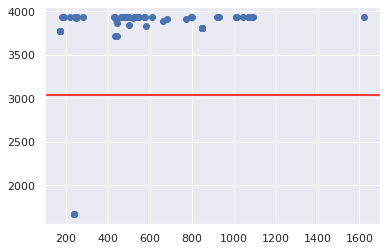

In [139]:
x_val = []
y_val = []
for point in topHyper2:
    if (point['systemCount']>0):
        x_val.append(point['systemCount'])
        y_val.append(point['matchCount'])
plt.scatter(x_val,y_val)
plt.axhline(3043,color="red")

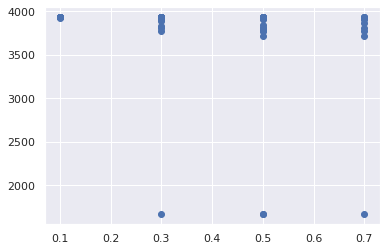

In [134]:
x_val = []
y_val = []
for point in topHyper2:
    if (point['systemCount']>0):
        x_val.append(point['thresh'])
        y_val.append(point['matchCount'])
plt.scatter(x_val,y_val)

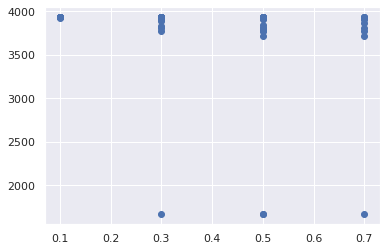

In [135]:
x_val = []
y_val = []
for point in topHyper2:
    if (point['systemCount']>0):
        x_val.append(point['thresh'])
        y_val.append(point['matchCount'])
plt.scatter(x_val,y_val)

In [32]:
Gorig0 = nx.read_edgelist("data/new/ppi.tsv", delimiter='\t' , nodetype=str,  data=(('weight',float),))
Gorig2 = Gorig0.subgraph(match)
Gorth = nx.read_edgelist("data/matched/reactome", delimiter='\t' , nodetype=str)

threshList =  [0.1,0.3,0.5,0.7,0.9]# [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
powerList = [0.0,0.3]
batchList = [150,50,15,5]
topCount = 0
butPower = 1
topOnt = []
topHyper3 = []
for thresh in threshList: 
    for power in powerList:
        for batch in batchList:
            maps, ontOut = f(thresh, power, batch,50,5,Gorig2)
            count = hypergeometricTestPairCount(Gorth,ontOut)
            topOnt.append(ontOut)
            topHyper2.append({"thresh":thresh, "power":power, "batch":batch, "systemCount":len(ontOut.terms),"matchCount":count})
            print(thresh,power,count)
            if (count > topCount) | ((count == topCount) & (power < butPower)):
                topCount = count
                butPower = power
                topMap = maps

entering supervised stage
root block
275 genes, 2047 terms, 451 gene-term relations, 3179 term-term relations
node_attributes: []
edge_attributes: []
0.1 0.0 3937
entering supervised stage
root block
275 genes, 555 terms, 467 gene-term relations, 891 term-term relations
node_attributes: []
edge_attributes: []
0.1 0.0 3937
entering supervised stage
root block
275 genes, 994 terms, 462 gene-term relations, 1544 term-term relations
node_attributes: []
edge_attributes: []
0.1 0.0 3937
entering supervised stage
breaking
0 genes, 0 terms, 0 gene-term relations, 0 term-term relations
node_attributes: []
edge_attributes: []
0.1 0.0 0
entering supervised stage
root block
275 genes, 799 terms, 633 gene-term relations, 1510 term-term relations
node_attributes: []
edge_attributes: []
0.1 0.2 3937
entering supervised stage
root block
275 genes, 201 terms, 671 gene-term relations, 322 term-term relations
node_attributes: []
edge_attributes: []
0.1 0.2 3937
entering supervised stage
root block
275 ge

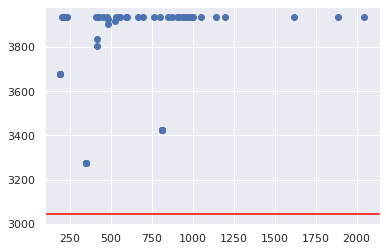

In [140]:
x_val = []
y_val = []
for point in topHyper3:
    if (point['systemCount']>0):
        x_val.append(point['systemCount'])
        y_val.append(point['matchCount'])
plt.scatter(x_val,y_val)
plt.axhline(3043,color="red")

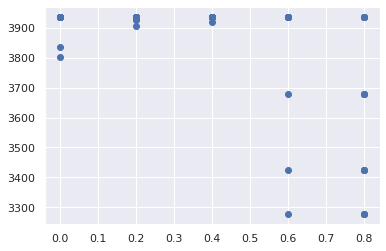

In [39]:
x_val = []
y_val = []
for point in topHyper3:
    if (point['systemCount']>0):
        x_val.append(point['power'])
        y_val.append(point['matchCount'])
plt.scatter(x_val,y_val)

In [262]:
ndex_server = 'http://ndexbio.org' 

# Set the NDEx server and the user account (replace with your own account)
ndex_user, ndex_pass = 'xiaoran.a.yan', 'a1l9i8f4e3'
url, _ = topOntMap.to_ndex(ndex_server=ndex_server, ndex_user=ndex_user, ndex_pass=ndex_pass)
print(url)

http://public.ndexbio.org/v2/network/5c470406-8bed-11eb-9e72-0ac135e8bacf


In [86]:
ont2.align(topOnt,calculateFDRs="../../alignOntology/calculateFDRs").sort_values(by='Term')
#topOnt.align(ont2,calculateFDRs="../../alignOntology/calculateFDRs").sort_index()

collapse command: /home/everyan/miniconda3/envs/tf-prob/lib/python3.7/site-packages/ddot/alignOntology/collapseRedundantNodes /tmp/tmpho78ox83
collapse command: /home/everyan/miniconda3/envs/tf-prob/lib/python3.7/site-packages/ddot/alignOntology/collapseRedundantNodes /tmp/tmp37fxh4if
Alignment command: ../../alignOntology/calculateFDRs /tmp/tmpa9zz4pnr /tmp/tmpq9psz0v4 0.05 criss_cross /tmp/tmpqafg31al 100 16 gene


/home/everyan/miniconda3/envs/tf-prob/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 'Term' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


,Term,Similarity,FDR
Term,,,
DNA replication,subsystem0,0.665553,0.000000
Chromatin remodelling,subsystem1,0.602734,0.000000
SHORT PATCH-BER factors,subsystem10,0.380793,0.000000
p53 pathway,subsystem11,0.885145,0.000000
MutL homologs,subsystem12,0.504807,0.000000
LONG PATCH-BER factors,subsystem13,0.731207,0.000000
Other single Ring- finger type E3,subsystem14,0.876015,0.025000
G1-CC phase,subsystem15,0.664008,0.000000
Ubiquitin ligases (E3),subsystem16,0.446222,0.000000


In [68]:
Gorig2 = nx.read_edgelist("data/matched/staging/rf_oob.avg.from_to.boost01Nov.tsv", delimiter='\t' , nodetype=str,  data=(('weight',float),))

threshList =  [0.1,0.3,0.5,0.7,0.9]# [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
powerList = [0.0,0.3]
batchList = [150,50,15,5]
topCount = 0
butPower = 1
topTable2 = []
topOnt2 = []
topHyper2 = []
for thresh in threshList: 
    for power in powerList:
        for batch in batchList:
            maps, ontOut = f(thresh, power, batch, 50, 5)
            table = ont2.align(ontOut,calculateFDRs="../../alignOntology/calculateFDRs")
            count = len(table[table['FDR']<=0.2])
            print(thresh,power,count)
            if (count > topCount) | ((count == topCount) & (power < butPower)):
                topCount = count
                butPower = power
                topTable2.append(table)
                topOnt2.append(ontOut)
                topMap = maps
                topHyper2.append({"thresh":thresh, "power":power, "batch":batch, "count":count})

TypeError: f() missing 1 required positional argument: 'Gorig2'

In [104]:
topOnt2

[336 genes, 1281 terms, 529 gene-term relations, 1987 term-term relations
 node_attributes: []
 edge_attributes: [],
 336 genes, 1026 terms, 551 gene-term relations, 1552 term-term relations
 node_attributes: []
 edge_attributes: [],
 336 genes, 855 terms, 776 gene-term relations, 1656 term-term relations
 node_attributes: []
 edge_attributes: []]

In [52]:
topHyper2

NameError: name 'topHyper2' is not defined

In [216]:
topTable2

[                         Term  Similarity   FDR
 Term                                           
 Repair pathway  subsystem1165    0.712287  0.01,
                                             Term  Similarity   FDR
 Term                                                              
 p53 pathway                         subsystem244    0.464399  0.07
 TCR (Transcription coupled repair)   subsystem29    0.167565  0.06
 Repair pathway                      subsystem553    0.714095  0.04,
                                             Term  Similarity   FDR
 Term                                                              
 TCR (Transcription coupled repair)  subsystem456    0.186067  0.00
 Repair pathway                      subsystem534    0.742101  0.02
 RPA (replication factor A)           subsystem50    0.441194  0.02
 Chromatin remodelling                subsystem61    0.449859  0.04,
                                                Term  Similarity    FDR
 Term                         

In [273]:
mapping2 = dict(zip(topTable2[3].Term,topTable2[3].index))
topG2 = topOnt2[3].to_networkx()
topG2 = nx.relabel_nodes(topG2, mapping2)
topOntMap2 = Ontology.from_networkx(topG2)
print(topOntMap2)

306 genes, 318 terms, 372 gene-term relations, 307 term-term relations
node_attributes: []
edge_attributes: []


In [246]:
url, _ = topOntMap2.to_ndex(ndex_server=ndex_server, ndex_user=ndex_user, ndex_pass=ndex_pass)
print(url)

http://public.ndexbio.org/v2/network/22fe0d83-8bd2-11eb-9e72-0ac135e8bacf


In [57]:
Gorig2 = G2.subgraph(match)
#maps, ontOut = f(0.1,0.2,5,500,50)
#threshList =  [0.1,0.3,0.5,0.7,0.9]# [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
#powerList = [0.0,0.2,0.4,0.6,0.8]
batchList = [5,10,20,30,50,80,100,200,500,1000]
topCount = 0
butPower = 1
topTable = []
topOnt = []
topHyper = []
for batch in batchList:
    maps, ontOut = f(0.1,0.2,50,batch,5)
    table = ontOut.align(ont2,calculateFDRs="../../alignOntology/calculateFDRs")
    count = len(table[table['FDR']<=0.2])
    print(batch,count)
    topCount = count
    topTable.append(table)
    topOnt.append(ontOut)
    topMap = maps
    topHyper.append({"batch":batch, "count":count})

entering supervised stage
45
231
(231, 45)
0.91560197
0.1
0.2
50
231
looping
2
2
(45, 45)
Adding CliXO candidates
(45, 45)
0.9153309
0.1
0.2
50
45
looping
0
0
(45, 45)
Adding CliXO candidates
(45, 45)
0.9152925
0.1
0.2
50
45
looping
0
0
(45, 45)
Adding CliXO candidates
(45, 45)
0.9152384
0.1
0.2
50
45
looping
0
0
(45, 45)
Adding CliXO candidates
(45, 45)
0.71527714
0.1
0.2
50
45
looping
0
0
(45, 45)
Adding CliXO candidates
(45, 45)
0.9151765
0.1
0.2
50
45
looping
0
0
(45, 45)
Adding CliXO candidates
(45, 45)
0.71539235
0.1
0.2
50
45
looping
0
0
(45, 45)
Adding CliXO candidates
(45, 45)
0.91519076
0.1
0.2
50
45
looping
0
0
(45, 45)
Adding CliXO candidates
(45, 45)
0.9150792
0.1
0.2
50
45
looping
0
0
(45, 45)
Adding CliXO candidates
(45, 45)
0.9150016
0.1
0.2
50
45
looping
0
0
(45, 45)
Adding CliXO candidates
(45, 45)
0.7150899
0.1
0.2
50
45
looping
0
0
(45, 45)
Adding CliXO candidates
(45, 45)
0.9149183
0.1
0.2
50
45
looping
0
0
(45, 45)
Adding CliXO candidates
(45, 45)
0.71501374
0.1
0

<BarContainer object of 10 artists>

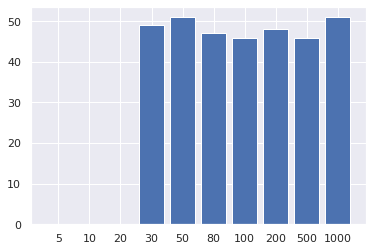

In [61]:
x = []
y = []
for h in topHyper:
    x.append(str(h["batch"]))
    y.append(h["count"])
    
plt.bar(x,y)

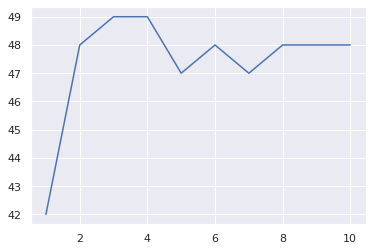

In [54]:
y[0]=42
plt.plot(x,y)